# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T

import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, classification_report, precision_recall_fscore_support, confusion_matrix, make_scorer

pd.set_option('max_rows', 1000)
pd.set_option('max_columns', 1000)

In [2]:
# create a Spark session
spark = SparkSession \
        .builder \
        .appName("Sparkify") \
        .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
path = 'mini_sparkify_event_data.json'

df = spark.read.json(path)
df = df.toPandas()
df.dtypes

artist            object
auth              object
firstName         object
gender            object
itemInSession      int64
lastName          object
length           float64
level             object
location          object
method            object
page              object
registration     float64
sessionId          int64
song              object
status             int64
ts                 int64
userAgent         object
userId            object
dtype: object

In [4]:
df.describe()

,itemInSession,length,registration,sessionId,status,ts
count,286500.000000,228108.000000,2.781540e+05,286500.000000,286500.000000,2.865000e+05
mean,114.414213,249.117182,1.535359e+12,1041.526555,210.054597,1.540957e+12
std,129.767262,99.235179,3.291322e+09,726.776263,31.505078,1.507544e+09
min,0.000000,0.783220,1.521381e+12,1.000000,200.000000,1.538352e+12
25%,27.000000,199.888530,1.533522e+12,336.000000,200.000000,1.539697e+12
50%,70.000000,234.500770,1.536664e+12,1013.000000,200.000000,1.540932e+12
75%,156.250000,277.158730,1.537672e+12,1675.000000,200.000000,1.542266e+12
max,1321.000000,3024.665670,1.543247e+12,2474.000000,404.000000,1.543799e+12


In [5]:
df.shape

(286500, 18)

In [6]:
# Check nulls
df.isnull().sum()

artist           58392
auth                 0
firstName         8346
gender            8346
itemInSession        0
lastName          8346
length           58392
level                0
location          8346
method               0
page                 0
registration      8346
sessionId            0
song             58392
status               0
ts                   0
userAgent         8346
userId               0
dtype: int64

In [7]:
# Check for invalid userIds
df.loc[df['userId'] == ''].count()

artist              0
auth             8346
firstName           0
gender              0
itemInSession    8346
lastName            0
length              0
level            8346
location            0
method           8346
page             8346
registration        0
sessionId        8346
song                0
status           8346
ts               8346
userAgent           0
userId           8346
dtype: int64

In [8]:
# Drop nulls, then convert userID to correct data type
df = df.loc[df['userId'] != '']
df['userId'] = df['userId'].astype(int)

In [9]:
# Repeat to check for blank session ids - none
df.loc[df['sessionId'] < 1].count()

artist           0
auth             0
firstName        0
gender           0
itemInSession    0
lastName         0
length           0
level            0
location         0
method           0
page             0
registration     0
sessionId        0
song             0
status           0
ts               0
userAgent        0
userId           0
dtype: int64

In [10]:
# Convert timestamp to date and time
df['ts2'] = pd.to_datetime(df.ts, unit='ms')
df['month'] = df['ts2'].dt.month
df['day'] = df['ts2'].dt.day
df['time'] = df['ts2'].dt.time
df['weekday'] = df['ts2'].dt.dayofweek
df['week'] = df['ts2'].dt.week

In [11]:
# Drop Guest users
df = df[df['auth'] != 'Guest']

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

In [12]:
df['userId'].nunique()

225

In [13]:
df.groupby('artist')['artist'].count()

artist
!!!                                                                                                                                                                           10
& And Oceans                                                                                                                                                                   1
'N Sync/Phil Collins                                                                                                                                                           4
'Til Tuesday                                                                                                                                                                   2
't Hof Van Commerce                                                                                                                                                            1
't Hof Van Commerce & Brahim                                                                                

In [14]:
df.groupby('page')['page'].count()

page
About                           495
Add Friend                     4277
Add to Playlist                6526
Cancel                           52
Cancellation Confirmation        52
Downgrade                      2055
Error                           252
Help                           1454
Home                          10082
Logout                         3226
NextSong                     228108
Roll Advert                    3933
Save Settings                   310
Settings                       1514
Submit Downgrade                 63
Submit Upgrade                  159
Thumbs Down                    2546
Thumbs Up                     12551
Upgrade                         499
Name: page, dtype: int64

In [15]:
df.groupby('gender')['gender'].count()

gender
F    154578
M    123576
Name: gender, dtype: int64

In [16]:
df.groupby('location')['location'].count()

location
Albany, OR                                          23
Albany-Schenectady-Troy, NY                        457
Alexandria, LA                                     955
Allentown-Bethlehem-Easton, PA-NJ                  815
Anchorage, AK                                     1496
Atlanta-Sandy Springs-Roswell, GA                 4236
Atlantic City-Hammonton, NJ                       2176
Austin-Round Rock, TX                             1682
Bakersfield, CA                                   1775
Baltimore-Columbia-Towson, MD                     2710
Billings, MT                                      2132
Birmingham-Hoover, AL                               75
Boston-Cambridge-Newton, MA-NH                   13873
Boulder, CO                                        872
Bozeman, MT                                        254
Bridgeport-Stamford-Norwalk, CT                    893
Buffalo-Cheektowaga-Niagara Falls, NY             1402
Charlotte-Concord-Gastonia, NC-SC                 7780
C

In [17]:
df.groupby('status')['status'].count()

status
200    254718
307     23184
404       252
Name: status, dtype: int64

In [18]:
df.groupby('method')['method'].count()

method
GET     20336
PUT    257818
Name: method, dtype: int64

In [19]:
df.groupby('level')['level'].count()

level
free     55721
paid    222433
Name: level, dtype: int64

In [20]:
df.groupby('length')['length'].count()

length
0.78322         1
2.16771         1
4.04853         2
4.83220         1
6.34730         1
7.83628         1
8.30649         1
9.01179         4
10.03057        1
10.52689        1
11.20608        1
11.25832        3
11.36281        1
11.49342        1
11.54567        1
11.93751        2
11.98975        7
12.22485        1
12.30322        2
12.43383        1
12.64281        1
12.66893        1
12.69506        2
13.16526        1
13.42649        1
13.63546        3
13.68771        1
13.92281        1
14.96771        2
15.12444        1
15.17669        1
15.22893        1
15.38567        1
15.56853        1
15.85587        6
15.90812        2
16.45669        4
17.16200        4
17.76281        1
17.97179        1
18.02404        1
18.05016        3
18.15465        1
18.41587        2
18.49424        1
18.91220        1
18.99057        1
19.51302        1
19.64363        3
20.06159        2
20.37506        1
20.45342        2
21.26322        1
21.49832        1
21.65506        8
21.

In [21]:
df.groupby('itemInSession')['itemInSession'].count()

itemInSession
0       2689
1       2818
2       2941
3       2917
4       2887
5       2836
6       2803
7       2776
8       2735
9       2693
10      2633
11      2596
12      2556
13      2513
14      2485
15      2456
16      2428
17      2385
18      2345
19      2322
20      2301
21      2266
22      2218
23      2190
24      2170
25      2143
26      2126
27      2099
28      2073
29      2040
30      2017
31      1990
32      1956
33      1927
34      1896
35      1877
36      1860
37      1835
38      1797
39      1774
40      1759
41      1744
42      1737
43      1707
44      1675
45      1649
46      1633
47      1606
48      1587
49      1572
50      1550
51      1528
52      1513
53      1502
54      1490
55      1471
56      1447
57      1422
58      1410
59      1408
60      1398
61      1363
62      1347
63      1337
64      1307
65      1296
66      1290
67      1267
68      1255
69      1238
70      1216
71      1205
72      1189
73      1171
74      1158
75      114

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [22]:
# Get all unique IDs associated with a cancellation confirmation page
churned_ids = list(df.loc[df['page'] == 'Cancellation Confirmation']['userId'].unique())

In [23]:
df['churn'] = df['userId'].map(lambda user: 1 if user in churned_ids else 0)

In [24]:
downgraded_ids = list(df.loc[df['page'] == 'Downgrade']['userId'].unique())

In [25]:
df['downgraded'] = df['userId'].map(lambda user: 1 if user in downgraded_ids else 0)

In [26]:
# Create downgraded and churned flag
users_both = list(df.loc[(df['churn'] == 1) & (df['downgraded'] == 1)].drop_duplicates(subset = 'userId')['userId'].unique())
df['c_and_d'] = df['userId'].map(lambda user: 1 if user in users_both else 0)

# Create downgraded only flag
users_downgrade_only = list(df.loc[(df['churn'] == 0) & (df['downgraded'] == 1)].drop_duplicates(subset = 'userId')['userId'].unique())
df['downgrade_only'] = df['userId'].map(lambda user: 1 if user in users_downgrade_only else 0)

# Create churned only flag
users_churn_only = list(df.loc[(df['churn'] == 1) & (df['downgraded'] == 0)].drop_duplicates(subset = 'userId')['userId'].unique())
df['churn_only'] = df['userId'].map(lambda user: 1 if user in users_churn_only else 0)

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [27]:
df.drop_duplicates(subset = 'userId').groupby(['churn_only'])['userId'].count()

churn_only
0    208
1     17
Name: userId, dtype: int64

In [28]:
df.drop_duplicates(subset = 'userId').groupby(['downgrade_only'])['userId'].count()

downgrade_only
0    106
1    119
Name: userId, dtype: int64

In [29]:
df.drop_duplicates(subset = 'userId').groupby(['c_and_d'])['userId'].count()

c_and_d
0    190
1     35
Name: userId, dtype: int64

In [30]:
df.drop_duplicates(subset = 'userId').groupby(['churn'])['userId'].count()

churn
0    173
1     52
Name: userId, dtype: int64

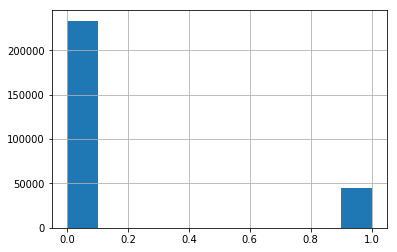

In [31]:
df['churn'].hist()

In [32]:
df.drop_duplicates(subset = 'userId').groupby(['downgraded'])['userId'].count()

downgraded
0     71
1    154
Name: userId, dtype: int64

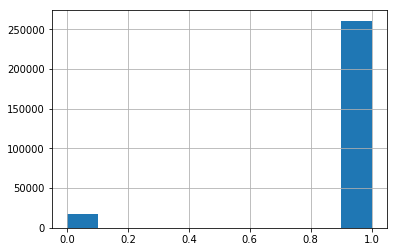

In [33]:
df['downgraded'].hist()

In [34]:
# Find number of users who both downgraded and then churned
df.loc[(df['churn'] == 1) & (df['downgraded'] == 1)].drop_duplicates(subset = 'userId')['userId'].nunique()

35

In [35]:
# Evaluate churn by free vs. paid users
df.drop_duplicates(subset = ['userId', 'level']).groupby(['churn', 'level'])['userId'].count()

churn  level
0      free     149
       paid     129
1      free      46
       paid      36
Name: userId, dtype: int64

In [36]:
# Evaluate downgrades by free vs. paid users
df.drop_duplicates(subset = ['userId', 'level']).groupby(['downgraded', 'level'])['userId'].count()

downgraded  level
0           free      68
            paid      11
1           free     127
            paid     154
Name: userId, dtype: int64

In [37]:
# Evaluate churn by gender
df.drop_duplicates(subset = ['userId', 'level']).groupby(['churn', 'gender'])['userId'].count()

churn  gender
0      F         135
       M         143
1      F          33
       M          49
Name: userId, dtype: int64

In [38]:
# Evaluate downgrades by gender
df.drop_duplicates(subset = ['userId', 'level']).groupby(['downgraded', 'gender'])['userId'].count()

downgraded  gender
0           F          31
            M          48
1           F         137
            M         144
Name: userId, dtype: int64

In [39]:
# Evaluate churn by gender and level
df.drop_duplicates(subset = ['userId', 'level']).groupby(['churn', 'level', 'gender'])['userId'].count()

churn  level  gender
0      free   F         70
              M         79
       paid   F         65
              M         64
1      free   F         19
              M         27
       paid   F         14
              M         22
Name: userId, dtype: int64

In [40]:
# Evaluate downgrades by gender and level
df.drop_duplicates(subset = ['userId', 'level']).groupby(['downgraded', 'level', 'gender'])['userId'].count()

downgraded  level  gender
0           free   F         27
                   M         41
            paid   F          4
                   M          7
1           free   F         62
                   M         65
            paid   F         75
                   M         79
Name: userId, dtype: int64

Evaluate page visits / behavior overall based on cancelled and active status.  Paid/free does not appear to influence.

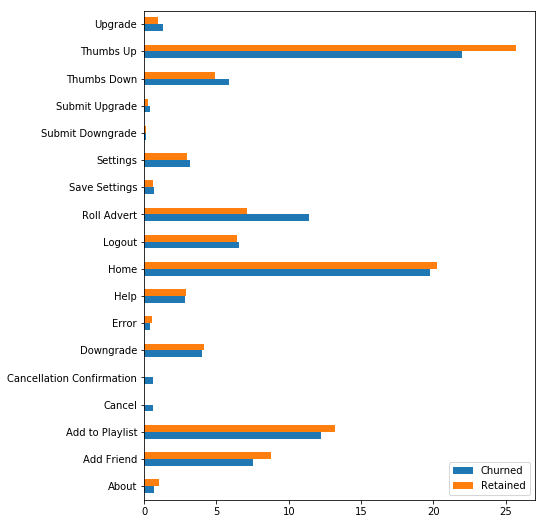

In [41]:
# Calculate % of each by page type
# Next Song page is 81% of hits, so drop that to see other meaningful behavior weighted more accurately
churned_users = df[df.churn == 1].groupby('page')['userId'].count().drop('NextSong')
churned_users = churned_users/churned_users.sum() * 100

#print(churned_users)

retained_users = df[df.churn == 0].groupby('page')['userId'].count().drop('NextSong')
retained_users = retained_users/retained_users.sum() * 100

#print(retained_users)

# Create dataframe of percentages, then plot
pct_df = pd.DataFrame({'Churned': churned_users, 'Retained': retained_users})

#pct_df.head(20)

pct_df.plot(kind = 'barh', figsize=(7, 9))

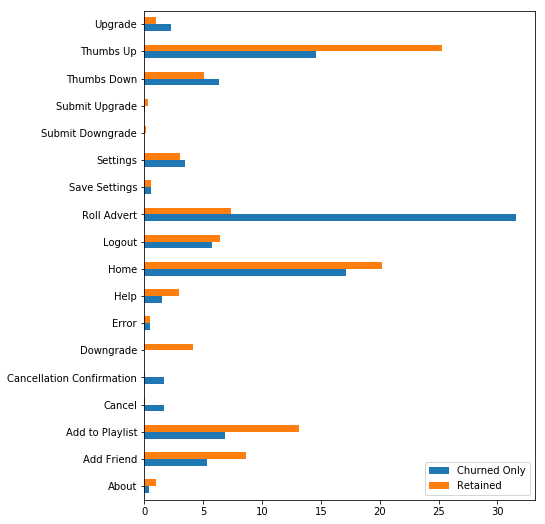

In [42]:
# Churn Only
# Calculate % of each by page type
# Next Song page is 81% of hits, so drop that to see other meaningful behavior weighted more accurately
churned_users = df[df.churn_only == 1].groupby('page')['userId'].count().drop('NextSong')
churned_users = churned_users/churned_users.sum() * 100

#print(churned_users)

retained_users = df[df.churn_only == 0].groupby('page')['userId'].count().drop('NextSong')
retained_users = retained_users/retained_users.sum() * 100

#print(retained_users)

# Create dataframe of percentages, then plot
pct_df = pd.DataFrame({'Churned Only': churned_users, 'Retained': retained_users})

#pct_df.head(20)

pct_df.plot(kind = 'barh', figsize=(7, 9))

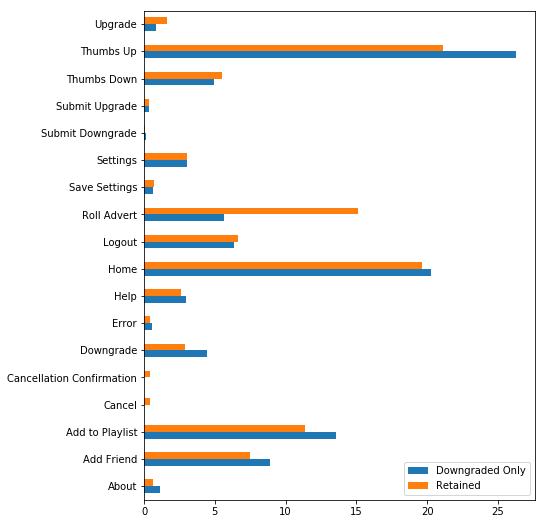

In [43]:
# Churn Only
# Calculate % of each by page type
# Next Song page is 81% of hits, so drop that to see other meaningful behavior weighted more accurately
churned_users = df[df.downgrade_only == 1].groupby('page')['userId'].count().drop('NextSong')
churned_users = churned_users/churned_users.sum() * 100

#print(churned_users)

retained_users = df[df.downgrade_only == 0].groupby('page')['userId'].count().drop('NextSong')
retained_users = retained_users/retained_users.sum() * 100

#print(retained_users)

# Create dataframe of percentages, then plot
pct_df = pd.DataFrame({'Downgraded Only': churned_users, 'Retained': retained_users})

#pct_df.head(20)

pct_df.plot(kind = 'barh', figsize=(7, 9))

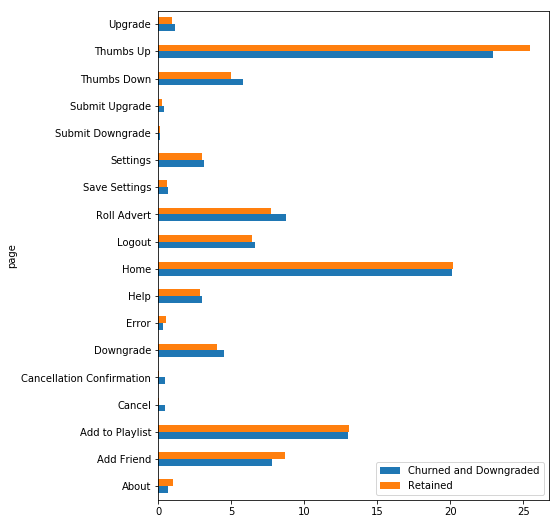

In [44]:
# Churn Only
# Calculate % of each by page type
# Next Song page is 81% of hits, so drop that to see other meaningful behavior weighted more accurately
churned_users = df[df.c_and_d == 1].groupby('page')['userId'].count().drop('NextSong')
churned_users = churned_users/churned_users.sum() * 100

#print(churned_users)

retained_users = df[df.c_and_d == 0].groupby('page')['userId'].count().drop('NextSong')
retained_users = retained_users/retained_users.sum() * 100

#print(retained_users)

# Create dataframe of percentages, then plot
pct_df = pd.DataFrame({'Churned and Downgraded': churned_users, 'Retained': retained_users})

#pct_df.head(20)

pct_df.plot(kind = 'barh', figsize=(7, 9))

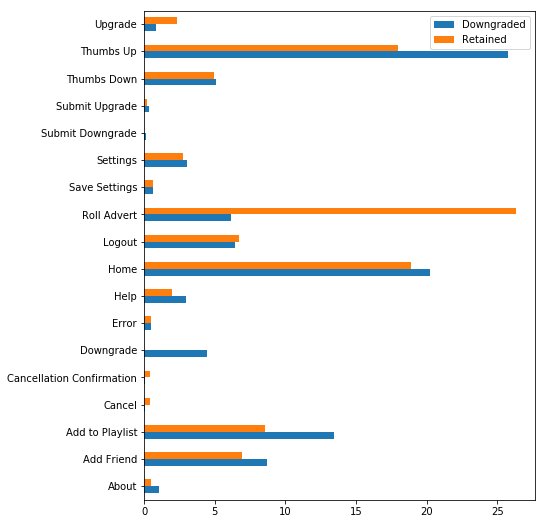

In [45]:
# Repeat for downgrades
# Calculate % of each by page type
# Next Song page is 81% of hits, so drop that to see other meaningful behavior weighted more accurately
churned_users = df[df.downgraded == 1].groupby('page')['userId'].count().drop('NextSong')
churned_users = churned_users/churned_users.sum() * 100

#print(churned_users)

retained_users = df[df.downgraded == 0].groupby('page')['userId'].count().drop('NextSong')
retained_users = retained_users/retained_users.sum() * 100

#print(retained_users)

# Create dataframe of percentages, then plot
pct_df = pd.DataFrame({'Downgraded': churned_users, 'Retained': retained_users})

#pct_df.head(20)

pct_df.plot(kind = 'barh', figsize=(7, 9))

In [46]:
df.columns

Index(['artist', 'auth', 'firstName', 'gender', 'itemInSession', 'lastName',
       'length', 'level', 'location', 'method', 'page', 'registration',
       'sessionId', 'song', 'status', 'ts', 'userAgent', 'userId', 'ts2',
       'month', 'day', 'time', 'weekday', 'week', 'churn', 'downgraded',
       'c_and_d', 'downgrade_only', 'churn_only'],
      dtype='object')

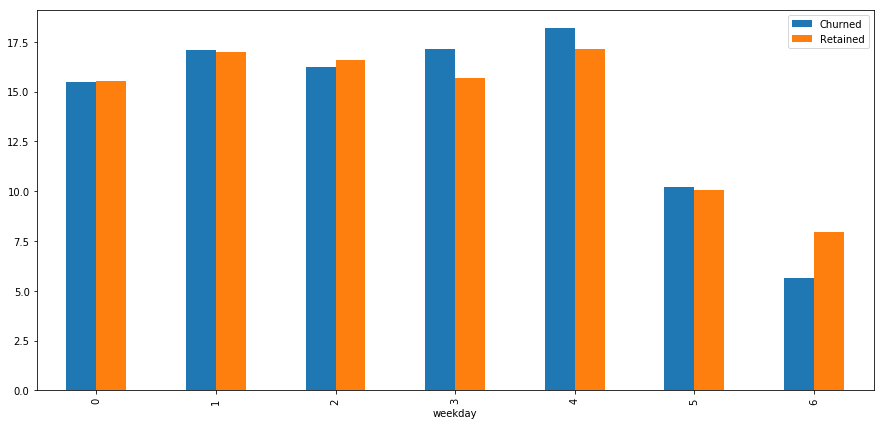

In [47]:
churned_users = df[df.churn == 1].groupby('weekday')['userId'].count()
churned_users = churned_users / churned_users.sum() * 100

retained_users = df[df.churn == 0].groupby('weekday')['userId'].count()
retained_users = retained_users/retained_users.sum() * 100

# Create dataframe of percentages, then plot
pct_df = pd.DataFrame({'Churned': churned_users, 'Retained': retained_users})

pct_df.plot(kind = 'bar', figsize=(15, 7))

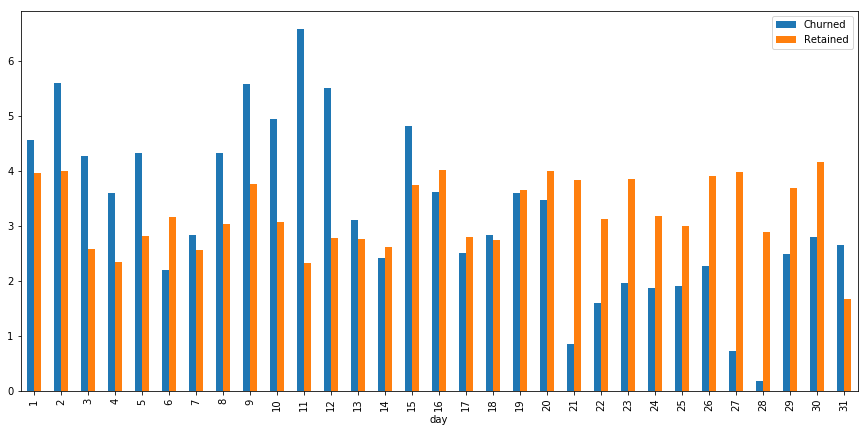

In [48]:
churned_users = df[df.churn == 1].groupby('day')['userId'].count()
churned_users = churned_users / churned_users.sum() * 100

retained_users = df[df.churn == 0].groupby('day')['userId'].count()
retained_users = retained_users/retained_users.sum() * 100

# Create dataframe of percentages, then plot
pct_df = pd.DataFrame({'Churned': churned_users, 'Retained': retained_users})

pct_df.plot(kind = 'bar', figsize=(15, 7))

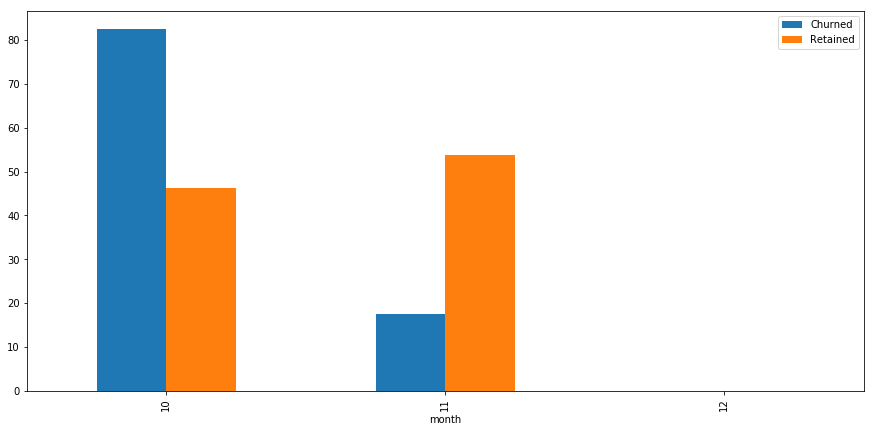

In [49]:
churned_users = df[df.churn == 1].groupby('month')['userId'].count()
churned_users = churned_users / churned_users.sum() * 100

retained_users = df[df.churn == 0].groupby('month')['userId'].count()
retained_users = retained_users/retained_users.sum() * 100

# Create dataframe of percentages, then plot
pct_df = pd.DataFrame({'Churned': churned_users, 'Retained': retained_users})

pct_df.plot(kind = 'bar', figsize=(15, 7))

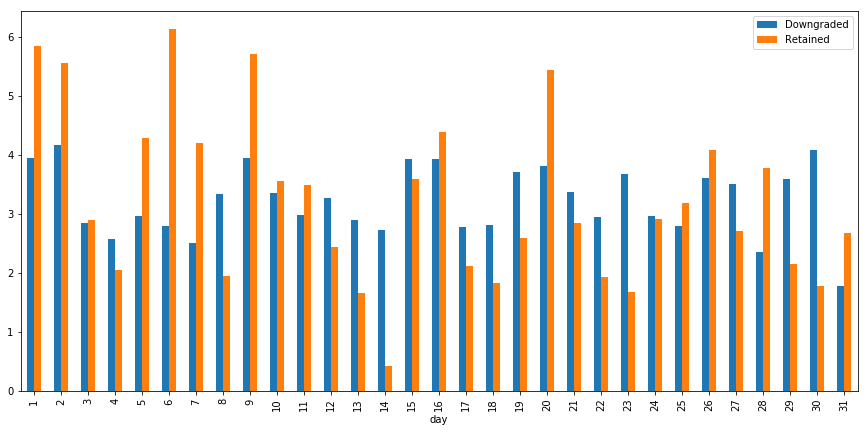

In [50]:
churned_users = df[df.downgraded == 1].groupby('day')['userId'].count()
churned_users = churned_users / churned_users.sum() * 100

retained_users = df[df.downgraded == 0].groupby('day')['userId'].count()
retained_users = retained_users/retained_users.sum() * 100

# Create dataframe of percentages, then plot
pct_df = pd.DataFrame({'Downgraded': churned_users, 'Retained': retained_users})

pct_df.plot(kind = 'bar', figsize=(15, 7))

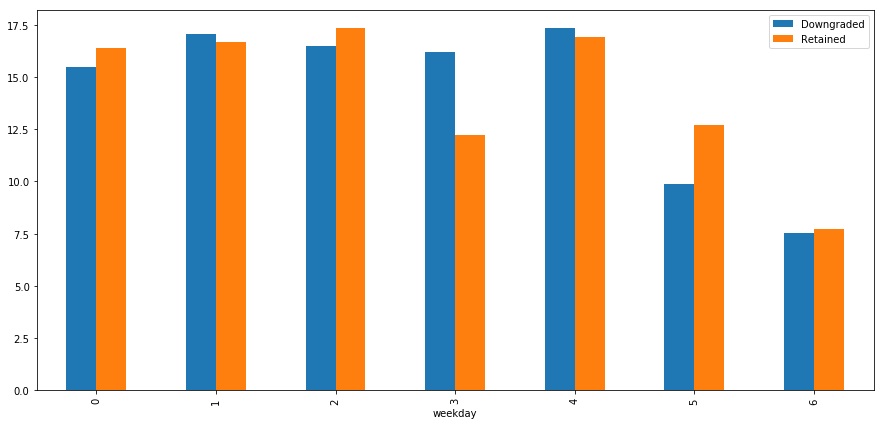

In [51]:
churned_users = df[df.downgraded == 1].groupby('weekday')['userId'].count()
churned_users = churned_users / churned_users.sum() * 100

retained_users = df[df.downgraded == 0].groupby('weekday')['userId'].count()
retained_users = retained_users/retained_users.sum() * 100

# Create dataframe of percentages, then plot
pct_df = pd.DataFrame({'Downgraded': churned_users, 'Retained': retained_users})

pct_df.plot(kind = 'bar', figsize=(15, 7))

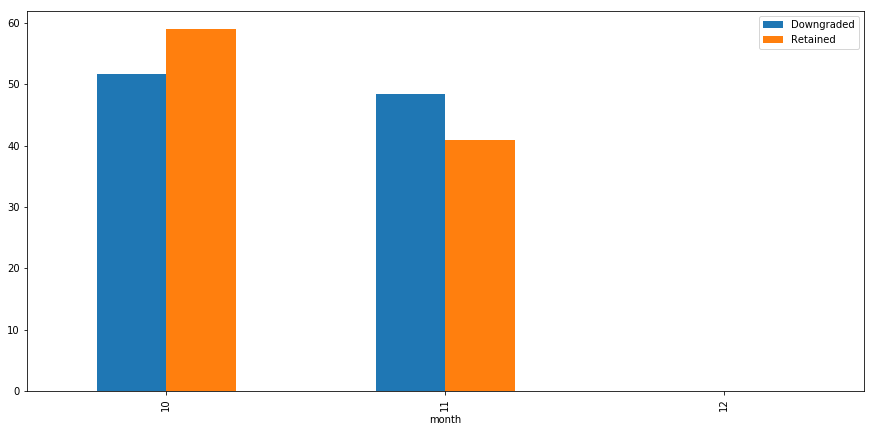

In [52]:
churned_users = df[df.downgraded == 1].groupby('month')['userId'].count()
churned_users = churned_users / churned_users.sum() * 100

retained_users = df[df.downgraded == 0].groupby('month')['userId'].count()
retained_users = retained_users/retained_users.sum() * 100

# Create dataframe of percentages, then plot
pct_df = pd.DataFrame({'Downgraded': churned_users, 'Retained': retained_users})

pct_df.plot(kind = 'bar', figsize=(15, 7))

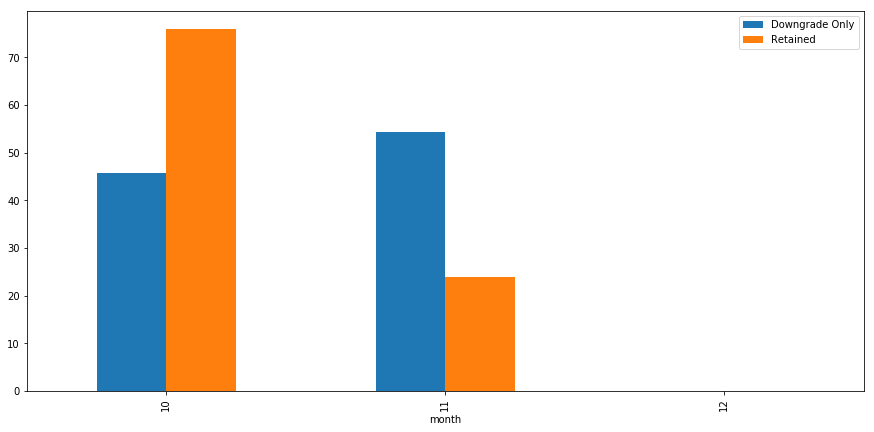

In [53]:
# How many downgraded only in October but then still were members in November?
churned_users = df[df.downgrade_only == 1].groupby('month')['userId'].count()
churned_users = churned_users / churned_users.sum() * 100

retained_users = df[df.downgrade_only == 0].groupby('month')['userId'].count()
retained_users = retained_users/retained_users.sum() * 100

# Create dataframe of percentages, then plot
pct_df = pd.DataFrame({'Downgrade Only': churned_users, 'Retained': retained_users})

pct_df.plot(kind = 'bar', figsize=(15, 7))

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

The first step is to create a user level dataset rather than a dataset that has rows for each session.

In [54]:
df.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,ts2,month,day,time,weekday,week,churn,downgraded,c_and_d,downgrade_only,churn_only
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-01 00:01:57,10,1,00:01:57,0,40,0,1,0,1,0
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,2018-10-01 00:03:00,10,1,00:03:00,0,40,0,1,0,1,0
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-01 00:06:34,10,1,00:06:34,0,40,0,1,0,1,0
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,2018-10-01 00:06:56,10,1,00:06:56,0,40,0,1,0,1,0
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-01 00:11:16,10,1,00:11:16,0,40,0,1,0,1,0


In [55]:
# Calculate total unique songs and artists listened to per user
df_agg_unique_listens = df.groupby('userId')['artist','song'].nunique() \
                        .rename(columns = {'artist': 'n_artist_total', 'song': 'n_song_total'})

In [56]:
# Find total songs listened to overall per user
df_agg_total_listens = pd.DataFrame(df.groupby('userId')['song'].count() \
                                    .rename(columns = {'song': 'total_listens'})) \
                                    .reset_index() \
                                    .rename(columns = {'index': 'userId', 0: 'total_songs'})

In [57]:
# Get other aggregate statistics at the user level
df_agg = df.groupby('userId')['gender','length','location','ts2','churn','downgraded', 'c_and_d', 'downgrade_only', 'churn_only'].max().rename(columns = {'ts2': 'max_date'})

In [58]:
# Merge into 1 dataset
df_agg_2 = df_agg.merge(df_agg_unique_listens, on = 'userId')
df_agg_2 = df_agg_2.merge(df_agg_total_listens, on = 'userId')
print(df_agg_2.head())

   userId gender      length                              location  \
0       2      F   715.70240                           Raleigh, NC   
1       3      M   796.78649                           Bozeman, MT   
2       4      M  1457.37098         Baltimore-Columbia-Towson, MD   
3       5      M   527.17669           Phoenix-Mesa-Scottsdale, AZ   
4       6      M  1059.08200  Houston-The Woodlands-Sugar Land, TX   

             max_date  churn  downgraded  c_and_d  downgrade_only  churn_only  \
0 2018-11-21 22:30:04      0           1        0               1           0   
1 2018-10-30 04:59:03      1           1        1               0           0   
2 2018-11-30 16:32:28      0           1        0               1           0   
3 2018-11-08 00:33:21      0           0        0               0           0   
4 2018-11-29 22:48:26      0           1        0               1           0   

   n_artist_total  n_song_total  total_songs  
0             587           713          755 

In [59]:
# Create weekly averages
df_unique_listens_wk = df.groupby(['userId','week'])['artist','song'].nunique()
df_unique_listens_wk = df_unique_listens_wk.groupby(['userId'])['artist','song'].mean().rename(columns = {'artist': 'n_artist_wk_avg', 'song': 'n_song_wk_avg'})

In [60]:
df_total_listens_wk = pd.DataFrame(df.groupby(['userId','week'])['song'].count()).reset_index()
df_total_listens_wk = df_total_listens_wk.groupby(['userId'])['song'].mean().reset_index().rename(columns = {'song': 'total_songs_wk_avg'})

In [61]:
# Add to overall dataframe
df_agg_2 = df_agg_2.merge(df_unique_listens_wk, on = 'userId')
df_agg_2 = df_agg_2.merge(df_total_listens_wk, on = 'userId')
df_agg_2.head()

,userId,gender,length,location,max_date,churn,downgraded,c_and_d,downgrade_only,churn_only,n_artist_total,n_song_total,total_songs,n_artist_wk_avg,n_song_wk_avg,total_songs_wk_avg
0,2,F,715.70240,"Raleigh, NC",2018-11-21 22:30:04,0,1,0,1,0,587,713,755,113.333333,122.666667,125.833333
1,3,M,796.78649,"Bozeman, MT",2018-10-30 04:59:03,1,1,1,0,0,197,211,214,68.333333,70.666667,71.333333
2,4,M,1457.37098,"Baltimore-Columbia-Towson, MD",2018-11-30 16:32:28,0,1,0,1,0,1342,1799,2048,198.555556,219.333333,227.555556
3,5,M,527.17669,"Phoenix-Mesa-Scottsdale, AZ",2018-11-08 00:33:21,0,0,0,0,0,154,159,161,39.500000,39.750000,40.250000
4,6,M,1059.08200,"Houston-The Woodlands-Sugar Land, TX",2018-11-29 22:48:26,0,1,0,1,0,1868,2678,3159,295.444444,335.777778,351.000000


Features most associated with retention are thumbs up, friends added, and add to playlist.  Features most associated with churn are thumbs down and roll advert.  These patterns become even more obvious when separating out users who straight churned from users who downgraded and churned.  Given that, let's calculate some ratios to capture these user behavior discrepancies.

In [62]:
user_page_totals = df[df['page'] != 'NextSong'].groupby(['userId','page'])['page'].count()

In [63]:
user_total_interactions = df[df['page'] != 'NextSong'].groupby(['userId'])['page'].count()

In [64]:
# calculate percentage engaged with per user per page overall
user_pct_page_ix = (user_page_totals / user_total_interactions * 100).rename('pct')

user_pct_page_ix = pd.DataFrame(user_pct_page_ix)

# pivot so each row represents 1 user and their percentages
user_pct_page_ix = pd.pivot_table(user_pct_page_ix, values = ['pct'], index = ['userId'], columns = ['page']) \
                    .reset_index().fillna(0)

# Clean column names and return object
user_pct_page_ix.columns = ["_".join((j,k)) for j,k in user_pct_page_ix.columns]
user_pct_page_ix.columns = [j.lower() for j in user_pct_page_ix.columns]
user_pct_page_ix.columns = [j.replace(' ','_') for j in user_pct_page_ix.columns]
user_pct_page_ix = user_pct_page_ix.rename(columns = {'userid_': 'userId'})
user_pct_page_ix.head()

,userId,pct_about,pct_add_friend,pct_add_to_playlist,pct_cancel,pct_cancellation_confirmation,pct_downgrade,pct_error,pct_help,pct_home,pct_logout,pct_roll_advert,pct_save_settings,pct_settings,pct_submit_downgrade,pct_submit_upgrade,pct_thumbs_down,pct_thumbs_up,pct_upgrade
0,2,2.083333,13.888889,9.027778,0.0,0.0,9.027778,0.000000,2.777778,24.305556,7.638889,0.000000,2.777778,4.166667,0.0,0.000000,4.166667,20.138889,0.000000
1,3,2.500000,2.500000,10.000000,2.5,2.5,5.000000,0.000000,2.500000,20.000000,7.500000,2.500000,0.000000,0.000000,0.0,0.000000,7.500000,35.000000,0.000000
2,4,1.522843,11.675127,14.974619,0.0,0.0,5.329949,1.015228,3.045685,20.304569,6.091371,1.015228,0.507614,2.538071,0.0,0.253807,6.598985,24.111675,1.015228
3,5,0.000000,5.263158,14.035088,0.0,0.0,0.000000,0.000000,3.508772,24.561404,7.017544,19.298246,1.754386,1.754386,0.0,0.000000,0.000000,19.298246,3.508772
4,6,0.498339,6.810631,13.787375,0.0,0.0,6.810631,0.664452,3.986711,21.926910,7.973422,1.495017,0.332226,2.823920,0.0,0.166113,5.149502,27.408638,0.166113


In [65]:
# Join as columns on userId to original df
df_merged = df_agg_2.merge(user_pct_page_ix, on = 'userId')

# Truncate location to state level only
df_merged['location'] = df_merged['location'].str[-2:]

In [66]:
df_merged.isnull().sum()

userId                           0
gender                           0
length                           0
location                         0
max_date                         0
churn                            0
downgraded                       0
c_and_d                          0
downgrade_only                   0
churn_only                       0
n_artist_total                   0
n_song_total                     0
total_songs                      0
n_artist_wk_avg                  0
n_song_wk_avg                    0
total_songs_wk_avg               0
pct_about                        0
pct_add_friend                   0
pct_add_to_playlist              0
pct_cancel                       0
pct_cancellation_confirmation    0
pct_downgrade                    0
pct_error                        0
pct_help                         0
pct_home                         0
pct_logout                       0
pct_roll_advert                  0
pct_save_settings                0
pct_settings        

In [67]:
# Quick state level eda
df_merged.groupby('location')['churn'].mean().sort_values(ascending = False)

location
MO    1.000000
OR    1.000000
AR    1.000000
KY    0.666667
MS    0.666667
OH    0.666667
MI    0.600000
CO    0.500000
LA    0.500000
KS    0.500000
MT    0.500000
MD    0.428571
AL    0.333333
WA    0.333333
AZ    0.285714
PA    0.277778
NC    0.222222
FL    0.214286
NY    0.200000
TX    0.187500
CA    0.181818
IN    0.166667
WV    0.166667
SC    0.125000
IL    0.111111
WI    0.100000
MA    0.000000
NH    0.000000
NJ    0.000000
ID    0.000000
IA    0.000000
GA    0.000000
NV    0.000000
CT    0.000000
OK    0.000000
TN    0.000000
UT    0.000000
VA    0.000000
AK    0.000000
Name: churn, dtype: float64

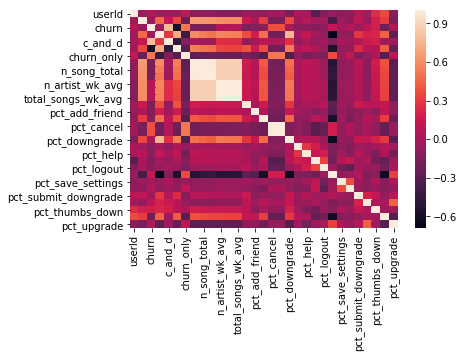

In [68]:
# Look at correlation between features
corr = df_merged.corr()
sns.heatmap(corr)

## Create Pipeline

In [69]:
# Drop columns not needed for modeling
df_merged = df_merged.drop(['max_date', 'userId', 'location', 'c_and_d','churn_only','downgrade_only', 'downgraded', 'pct_cancel', 'pct_cancellation_confirmation'], axis = 1)
df_merged.head()

,gender,length,churn,n_artist_total,n_song_total,total_songs,n_artist_wk_avg,n_song_wk_avg,total_songs_wk_avg,pct_about,pct_add_friend,pct_add_to_playlist,pct_downgrade,pct_error,pct_help,pct_home,pct_logout,pct_roll_advert,pct_save_settings,pct_settings,pct_submit_downgrade,pct_submit_upgrade,pct_thumbs_down,pct_thumbs_up,pct_upgrade
0,F,715.70240,0,587,713,755,113.333333,122.666667,125.833333,2.083333,13.888889,9.027778,9.027778,0.000000,2.777778,24.305556,7.638889,0.000000,2.777778,4.166667,0.0,0.000000,4.166667,20.138889,0.000000
1,M,796.78649,1,197,211,214,68.333333,70.666667,71.333333,2.500000,2.500000,10.000000,5.000000,0.000000,2.500000,20.000000,7.500000,2.500000,0.000000,0.000000,0.0,0.000000,7.500000,35.000000,0.000000
2,M,1457.37098,0,1342,1799,2048,198.555556,219.333333,227.555556,1.522843,11.675127,14.974619,5.329949,1.015228,3.045685,20.304569,6.091371,1.015228,0.507614,2.538071,0.0,0.253807,6.598985,24.111675,1.015228
3,M,527.17669,0,154,159,161,39.500000,39.750000,40.250000,0.000000,5.263158,14.035088,0.000000,0.000000,3.508772,24.561404,7.017544,19.298246,1.754386,1.754386,0.0,0.000000,0.000000,19.298246,3.508772
4,M,1059.08200,0,1868,2678,3159,295.444444,335.777778,351.000000,0.498339,6.810631,13.787375,6.810631,0.664452,3.986711,21.926910,7.973422,1.495017,0.332226,2.823920,0.0,0.166113,5.149502,27.408638,0.166113


In [70]:
# Separate X and Y
y = pd.DataFrame(df_merged['churn'])
modeling_cols = [x for x in df_merged.columns if x not in y.columns]
X = df_merged[modeling_cols]

In [71]:
# Encode categoricals
X = pd.get_dummies(X, drop_first = True, dummy_na=False)
X.head()

,length,n_artist_total,n_song_total,total_songs,n_artist_wk_avg,n_song_wk_avg,total_songs_wk_avg,pct_about,pct_add_friend,pct_add_to_playlist,pct_downgrade,pct_error,pct_help,pct_home,pct_logout,pct_roll_advert,pct_save_settings,pct_settings,pct_submit_downgrade,pct_submit_upgrade,pct_thumbs_down,pct_thumbs_up,pct_upgrade,gender_M
0,715.70240,587,713,755,113.333333,122.666667,125.833333,2.083333,13.888889,9.027778,9.027778,0.000000,2.777778,24.305556,7.638889,0.000000,2.777778,4.166667,0.0,0.000000,4.166667,20.138889,0.000000,0
1,796.78649,197,211,214,68.333333,70.666667,71.333333,2.500000,2.500000,10.000000,5.000000,0.000000,2.500000,20.000000,7.500000,2.500000,0.000000,0.000000,0.0,0.000000,7.500000,35.000000,0.000000,1
2,1457.37098,1342,1799,2048,198.555556,219.333333,227.555556,1.522843,11.675127,14.974619,5.329949,1.015228,3.045685,20.304569,6.091371,1.015228,0.507614,2.538071,0.0,0.253807,6.598985,24.111675,1.015228,1
3,527.17669,154,159,161,39.500000,39.750000,40.250000,0.000000,5.263158,14.035088,0.000000,0.000000,3.508772,24.561404,7.017544,19.298246,1.754386,1.754386,0.0,0.000000,0.000000,19.298246,3.508772,1
4,1059.08200,1868,2678,3159,295.444444,335.777778,351.000000,0.498339,6.810631,13.787375,6.810631,0.664452,3.986711,21.926910,7.973422,1.495017,0.332226,2.823920,0.0,0.166113,5.149502,27.408638,0.166113,1


In [72]:
# Normalize
X_2 = Normalizer().fit_transform(X)
X_2 = pd.DataFrame(X_2, columns = X.columns)
X_2.head()

,length,n_artist_total,n_song_total,total_songs,n_artist_wk_avg,n_song_wk_avg,total_songs_wk_avg,pct_about,pct_add_friend,pct_add_to_playlist,pct_downgrade,pct_error,pct_help,pct_home,pct_logout,pct_roll_advert,pct_save_settings,pct_settings,pct_submit_downgrade,pct_submit_upgrade,pct_thumbs_down,pct_thumbs_up,pct_upgrade,gender_M
0,0.508578,0.417122,0.506658,0.536503,0.080535,0.087167,0.089417,0.001480,0.009869,0.006415,0.006415,0.000000,0.001974,0.017272,0.005428,0.000000,0.001974,0.002961,0.0,0.000000,0.002961,0.014311,0.000000,0.000000
1,0.901816,0.222968,0.238813,0.242209,0.077341,0.079982,0.080736,0.002830,0.002830,0.011318,0.005659,0.000000,0.002830,0.022636,0.008489,0.002830,0.000000,0.000000,0.0,0.000000,0.008489,0.039614,0.000000,0.001132
2,0.429823,0.395796,0.530579,0.604017,0.058560,0.064688,0.067113,0.000449,0.003443,0.004416,0.001572,0.000299,0.000898,0.005988,0.001797,0.000299,0.000150,0.000749,0.0,0.000075,0.001946,0.007111,0.000299,0.000295
3,0.879548,0.256935,0.265277,0.268614,0.065902,0.066319,0.067154,0.000000,0.008781,0.023416,0.000000,0.000000,0.005854,0.040979,0.011708,0.032197,0.002927,0.002927,0.0,0.000000,0.000000,0.032197,0.005854,0.001668
4,0.225352,0.397475,0.569827,0.672175,0.062865,0.071447,0.074686,0.000106,0.001449,0.002934,0.001449,0.000141,0.000848,0.004666,0.001697,0.000318,0.000071,0.000601,0.0,0.000035,0.001096,0.005832,0.000035,0.000213


# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [73]:
# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_2, y, test_size = 0.3, random_state = 42)
print(X_train.columns)

Index(['length', 'n_artist_total', 'n_song_total', 'total_songs',
       'n_artist_wk_avg', 'n_song_wk_avg', 'total_songs_wk_avg', 'pct_about',
       'pct_add_friend', 'pct_add_to_playlist', 'pct_downgrade', 'pct_error',
       'pct_help', 'pct_home', 'pct_logout', 'pct_roll_advert',
       'pct_save_settings', 'pct_settings', 'pct_submit_downgrade',
       'pct_submit_upgrade', 'pct_thumbs_down', 'pct_thumbs_up', 'pct_upgrade',
       'gender_M'],
      dtype='object')


In [74]:
# Build evaluation function
def __evaluate_model(y_test, y_preds):
    accuracy = accuracy_score(y_test, y_preds)
    precision = precision_score(y_test, y_preds, average = 'micro')
    recall = recall_score(y_test, y_preds, average = 'micro')
    f1 = f1_score(y_test, y_preds, average = 'micro')
    
    return accuracy, precision, recall, f1

In [75]:
def __get_feature_importance(model):

    importances = model.feature_importances_
    names = [i for i in X_2.columns]

    imp_df = pd.DataFrame(importances, names).reset_index() \
                    .rename(columns = {'index': 'Variable', 0: 'Importance'}) \
                    .sort_values(by = 'Importance', ascending = False)

    return imp_df

### Logistic Regression

In [76]:
# Create modeling object
model = LogisticRegression(random_state = 42)
print('Model Parameters:', model.get_params)

# Fit model
model.fit(X_train, y_train)

# Predict using model
y_preds = model.predict(X_test)

# Evaluate
accuracy, precision, recall, f1 = __evaluate_model(y_test, y_preds)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1:', f1)

Model Parameters: <bound method BaseEstimator.get_params of LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)>
Accuracy: 0.735294117647
Precision: 0.735294117647
Recall: 0.735294117647
F1: 0.735294117647


/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Random Forest Classifier

Model Parameters: <bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=7,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)>
Accuracy: 0.794117647059
Precision: 0.794117647059
Recall: 0.794117647059
F1: 0.794117647059


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


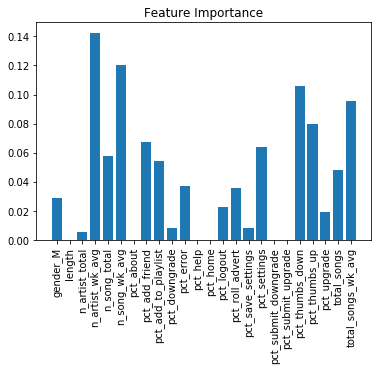

In [78]:
# Create modeling object
model = RandomForestClassifier(random_state = 42, max_depth = 10, max_leaf_nodes = 7)
print('Model Parameters:', model.get_params)

# Fit model
model.fit(X_train, y_train)

# Predict using model
y_preds = model.predict(X_test)

# Evaluate
accuracy, precision, recall, f1 = __evaluate_model(y_test, y_preds)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1:', f1)


# Feature Importance plot
imp_df = __get_feature_importance(model)

# Create plot
plt.figure()
plt.title("Feature Importance")
plt.bar(imp_df['Variable'], imp_df['Importance'])
plt.xticks(rotation=90)
plt.show()

### Gradient Boosted Classifier

Model Parameters: <bound method BaseEstimator.get_params of GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=7, max_leaf_nodes=5, min_impurity_decrease=0.0,
              min_impurity_split=None, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=42,
              subsample=1.0, verbose=0, warm_start=False)>
Accuracy: 0.779411764706
Precision: 0.779411764706
Recall: 0.779411764706
F1: 0.779411764706


/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


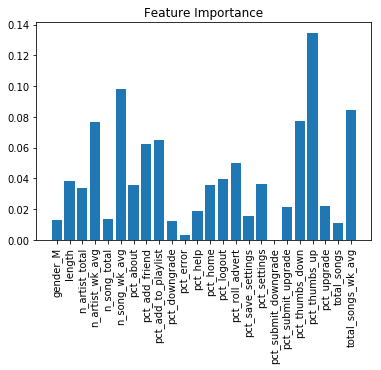

In [79]:
# Make scorer
#f1_scorer = make_scores(__get_scores

# Create modeling object
model = GradientBoostingClassifier(random_state = 42, max_features = 7, max_leaf_nodes = 5) #GridSearchCV(pipeline, param_grid = parameters, scoring = f1_scorer)
print('Model Parameters:', model.get_params)

# Fit model
model.fit(X_train, y_train)

# Predict using model
y_preds = model.predict(X_test)

# Evaluate
accuracy, precision, recall, f1 = __evaluate_model(y_test, y_preds)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1:', f1)


# Feature Importance plot
imp_df = __get_feature_importance(model)

# Create plot
plt.figure()
plt.title("Feature Importance")
plt.bar(imp_df['Variable'], imp_df['Importance'])
plt.xticks(rotation=90)
plt.show()

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.